# Figure 4

## Evaluation of trained networks

To load the training checkpoints, we first define the network architecture again.

## 1) Configuration

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import os
import numpy as np

from matplotlib import pyplot as plt
from IPython import display

Limit GPU memory usage by Tensorflow:

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

Global parameters are location of training data and loss function:

In [3]:
PATH = 'data/'
LOSS = 'frc+ssim+0.1*l1'

----

## 2) Input data

Normalize images to [-1, 1] and mean zero:

In [4]:
def normalize(input_image, real_image):
  input_image = input_image-tf.reduce_min(input_image)
  real_image = real_image-tf.reduce_min(real_image)
  imax = tf.reduce_max(input_image)
  rmax = tf.reduce_max(real_image)
  input_image = (2.0 * input_image / imax) - 1.0
  real_image = (2.0 * real_image / rmax) - 1.0

  return input_image, real_image

Load function for images:

In [5]:
@tf.autograph.experimental.do_not_convert
def load_image(image_file):
    
    input_image = tf.io.read_file(image_file)
    input_image = tf.image.decode_png(input_image,dtype=tf.dtypes.uint16)

    real_image = tf.io.read_file(tf.strings.regex_replace(image_file, "sub.*", "full.png"))
    real_image = tf.image.decode_png(real_image,dtype=tf.dtypes.uint16)

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    
    im_stack = tf.stack( (input_image, real_image) )
    im_stack = tf.image.central_crop(im_stack, 0.8)
    im_stack = tf.image.random_crop(im_stack, size=(2, 750, 750, 1))
    input_image, real_image = tf.unstack(im_stack, 2)
    
    input_image, real_image = normalize(input_image, real_image)

    f1 = tf.random.uniform(shape=[], dtype=tf.float32)# * tf.constant(np.pi)
    
    input_image = tfa.image.rotate(input_image, f1 * tf.constant(2.0 * np.pi))
    real_image = tfa.image.rotate(real_image, f1 * tf.constant(2.0 * np.pi))

    input_image = tf.image.crop_to_bounding_box(input_image, 119, 119, 512, 512)
    real_image = tf.image.crop_to_bounding_box(real_image, 119, 119, 512, 512)

    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

Test dataset:

In [6]:
test_dataset = tf.data.Dataset.list_files(PATH + '/test/*sub*.png')
test_dataset = test_dataset.map(load_image)
test_dataset = test_dataset.batch(1)

----

## 3) Define the model

We use the generator of the pix2pix U-Net adapted from https://www.tensorflow.org/tutorials/generative/pix2pix.

Downsampling step:

In [7]:
def downsample(filters, size, apply_batchnorm=True):

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

Upsampling step:

In [8]:
def upsample(filters, size, apply_dropout=False):

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

U-Net with downsampling, upsampling and skip connections:

In [9]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[512, 512, 1])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  last = tf.keras.layers.Conv2DTranspose(1, 4,
                                         strides=2,
                                         padding='same',
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs
    
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

----

## 4) FRC loss

Pre-compute kernels for normalization:

In [10]:
size = 512
size_half = 256

r = np.zeros([size])
r[:size_half] = np.arange(size_half)+1
r[size_half:] = np.arange(size_half,0,-1)

c=np.zeros([size])
c[:size_half] = np.arange(size_half)+1
c[size_half:] = np.arange(size_half,0,-1)

[R,C] = np.meshgrid(r,c)

help_index = np.round(np.sqrt(R**2+C**2))
kernel_list = []

for i in range(1, size_half+1):
    new_matrix = np.zeros(shape=[size,size])
    new_matrix[help_index==i]=1
    kernel_list.append(new_matrix)

kernel_list = tf.constant(kernel_list, dtype=tf.complex64)

Calculate the area of the FRC of two images using tensor functions:

In [11]:
@tf.function()
def FRC_loss(i1, i2, kernel_list):

    i1 = tf.squeeze(i1, axis = 0)
    i1 = tf.squeeze(i1, axis = -1)
    
    i2 = tf.squeeze(i2, axis = 0)
    i2 = tf.squeeze(i2, axis = -1)

    i1 = tf.cast(i1, dtype = tf.complex64)
    i2 = tf.cast(i2, dtype = tf.complex64)
    
    I1 = tf.signal.fft2d(i1)   
    I2 = tf.signal.fft2d(i2)
    
    A = tf.multiply(I1, tf.math.conj(I2))
    B = tf.multiply(I1, tf.math.conj(I1))   
    C = tf.multiply(I2, tf.math.conj(I2))

    A_val = tf.reduce_mean(tf.multiply(A, kernel_list), axis=(1,2))
    B_val = tf.reduce_mean(tf.multiply(B, kernel_list), axis=(1,2))
    C_val = tf.reduce_mean(tf.multiply(C, kernel_list), axis=(1,2))
 
    den = tf.sqrt(tf.abs(tf.multiply(B_val,C_val)))
    
    res = tf.abs(A_val) / den
    
    return 1.0 - tf.reduce_sum(res) / 256.0

----

## 5) Create network model

Define the different losses for training and monitoring, and evaluate loss term:

In [12]:
def generator_loss(gen_output, target):

    ab    = tf.reduce_mean(tf.abs(gen_output+1))
    l1    = tf.reduce_mean(tf.abs(gen_output-target))
    l2    = tf.reduce_mean(tf.square(gen_output-target))
    ssim  = tf.reduce_mean(1-tf.image.ssim_multiscale(gen_output, target, 2))
    frc   = FRC_loss(gen_output*0.5+0.5,target*0.5+0.5,kernel_list)
    psnr  = tf.squeeze(1/tf.image.psnr(gen_output, target, 2), axis = 0)
    tv    = tf.squeeze(tf.image.total_variation(gen_output), axis = 0)

    total_loss =  eval(LOSS)
        
    assert_op = tf.debugging.assert_all_finite(total_loss,'loss')


    return total_loss, ab, l1, l2, ssim, frc, psnr, tv

Define optimizer:

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

Create model instance:

In [14]:
generator = Generator()

----

## 6) Load checkpoints and compare predictions

Now, we load the different training checkpoints and compare the metrics of the predictions. Results are slightly different each time due to the random sampling from the data, but in all cases the combined loss has the best compromise between all metrics.

Initialize array for the results and set checkpoint directory:

In [15]:
allres = np.zeros((20,8,3));

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,generator=generator)

Load trained network for SSIM loss and generate 20 predictions from the test set:

In [16]:
checkpoint.restore(tf.train.latest_checkpoint('data/checkpoints/ssim'))

i=0;

while(i<20):
    for inp, tar in test_dataset.take(1):
        prediction = generator(inp, training=True)
        allres[i,:,0] = generator_loss(prediction, tar)
        i = i+1

Load trained network for FRC loss and generate 20 predictions from the test set:

In [17]:
checkpoint.restore(tf.train.latest_checkpoint('data/checkpoints/frc'))

i=0;

while(i<20):
    for inp, tar in test_dataset.take(1):
        prediction = generator(inp, training=True)
        allres[i,:,1] = generator_loss(prediction, tar)
        i = i+1

Load trained network for FRC + SSIM loss and generate 20 predictions from the test set:

In [18]:
checkpoint.restore(tf.train.latest_checkpoint('data/checkpoints/ssim+frc'))

i=0;

while(i<20):
    for inp, tar in test_dataset.take(1):
        prediction = generator(inp, training=True)
        allres[i,:,2] = generator_loss(prediction, tar)
        i = i+1

Plot mean$\pm$SE of MSE loss for all three loss functions:

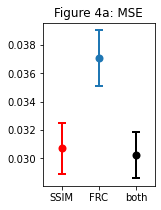

In [19]:
from scipy.stats import sem

plt.figure(figsize=(2, 3))
plt.errorbar(1,np.mean(allres[:,3,0]), yerr=sem(allres[:,3,0]), color="red", marker='o', elinewidth=2, capsize=4, markeredgewidth=2)
plt.errorbar(2,np.mean(allres[:,3,1]), yerr=sem(allres[:,3,1]), marker='o', elinewidth=2, capsize=4, markeredgewidth=2)
plt.errorbar(3,np.mean(allres[:,3,2]), yerr=sem(allres[:,3,2]), color="black", marker='o', elinewidth=2, capsize=4, markeredgewidth=2)
plt.title("Figure 4a: MSE")
plt.xticks(ticks=(1,2,3),labels=("SSIM","FRC","both"))
plt.xlim((0.5,3.5))
plt.show()

Plot mean$\pm$SE of FRC loss for all three loss functions:

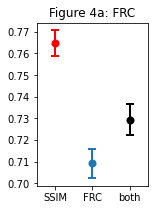

In [20]:
from scipy.stats import sem

plt.figure(figsize=(2, 3))
plt.errorbar(1,np.mean(allres[:,5,0]), yerr=sem(allres[:,5,0]), color="red", marker='o', elinewidth=2, capsize=4, markeredgewidth=2)
plt.errorbar(2,np.mean(allres[:,5,1]), yerr=sem(allres[:,5,1]), marker='o', elinewidth=2, capsize=4, markeredgewidth=2)
plt.errorbar(3,np.mean(allres[:,5,2]), yerr=sem(allres[:,5,2]), color="black", marker='o', elinewidth=2, capsize=4, markeredgewidth=2)
plt.title("Figure 4a: FRC")
plt.xticks(ticks=(1,2,3),labels=("SSIM","FRC","both"))
plt.xlim((0.5,3.5))
plt.show()

Plot mean$\pm$SE of 1/PSNR for all three loss functions:

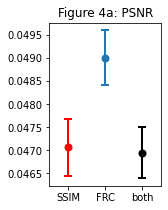

In [21]:
from scipy.stats import sem

plt.figure(figsize=(2, 3))
plt.errorbar(1,np.mean(allres[:,6,0]), yerr=sem(allres[:,6,0]), color="red", marker='o', elinewidth=2, capsize=4, markeredgewidth=2)
plt.errorbar(2,np.mean(allres[:,6,1]), yerr=sem(allres[:,6,1]), marker='o', elinewidth=2, capsize=4, markeredgewidth=2)
plt.errorbar(3,np.mean(allres[:,6,2]), yerr=sem(allres[:,6,2]), color="black", marker='o', elinewidth=2, capsize=4, markeredgewidth=2)
plt.title("Figure 4a: PSNR")
plt.xticks(ticks=(1,2,3),labels=("SSIM","FRC","both"))
plt.xlim((0.5,3.5))
plt.show()

Plot mean$\pm$SE of SSIM loss for all three loss functions:

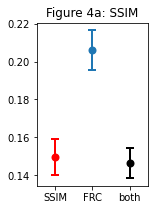

In [22]:
from scipy.stats import sem

plt.figure(figsize=(2, 3))
plt.errorbar(1,np.mean(allres[:,4,0]), yerr=sem(allres[:,4,0]), color="red", marker='o', elinewidth=2, capsize=4, markeredgewidth=2)
plt.errorbar(2,np.mean(allres[:,4,1]), yerr=sem(allres[:,4,1]), marker='o', elinewidth=2, capsize=4, markeredgewidth=2)
plt.errorbar(3,np.mean(allres[:,4,2]), yerr=sem(allres[:,4,2]), color="black", marker='o', elinewidth=2, capsize=4, markeredgewidth=2)
plt.title("Figure 4a: SSIM")
plt.xticks(ticks=(1,2,3),labels=("SSIM","FRC","both"))
plt.xlim((0.5,3.5))
plt.show()